# Text Clustering with K-Means
In the present notebook we will use the [k-means algorithm](https://www.datascience.com/blog/k-means-clustering), a simple and popular __*unsupervised clustering*__ algorithm, to cluster the national anthems of the world into different groups.

The objective of K-means is simple: group similar data points together and discover underlying patterns. To achieve this objective, K-means looks for a fixed defined number (k) of centroids in a dataset. A centroid refers to a cluster, which is a collection of data points aggregated together because of certain similarities with each other. The ‘means’ in the K-means refers to the averaging of the data; that is, finding the centroid. And the algorithm is said to be unsupervised because we have no prior knowledge with regards to the groups or classes of our dataset, that is, we will find the underlying groups in our dataset!

Below we can visualize the algorithm. The green centroids matches the closest datapoints to each one and form clusters, then each centroid moves to the center of each respective group and matches again the closest datapoint to each other.

![alt text](Images/kmeans.gif "Title")

**Steps:**

__1.__ Explore our collection of national anthems (corpus) <br>
__2.__ Data Engineer the dataset to get the best perfomance from the K-means algorithm <br>
__3.__ Run the algorithm many times, each time testing with a different number of clusters <br>
__4.__ Use different metrics to visualize our results and find the best number of clusters (*ie. Why are a total of X clusters better than a total of Y clusters*) <br>
__5.__ Cluster Analysis

**Metrics Utilized for Determining the Best Number of K Cluters:**
- [Elbow Method](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
- [Silhouette Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

## Importing Libraries:

In [1]:
# Data Structures
import numpy  as np
import pandas as pd
# import geopandas as gpd
import json

# Corpus Processing
import re
import nltk.corpus
# from unidecode                        import unidecode
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

# K-Means
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score
from wordcloud                        import WordCloud

# Map Viz
# import folium
#import branca.colormap as cm
# from branca.element import Figure

In [2]:
# Read the CSV file
data = pd.read_csv('./lyrics_p.csv')

# Filter rows for each decade and sample 100 rows from each
random_samples = []

# Decades to consider
decades = [(1930, 1939), (1940, 1949), (1950, 1959) ,(1960,1969),(1970,1979),(1980,1989),(1990,1999),(2000,2009)]

for decade in decades:
    start_year, end_year = decade
    decade_data = data[(data['Year'] >= start_year) & (data['Year'] <= end_year)]
    sample = decade_data.sample(n=100)  # Sampling 100 rows from each decade
    random_samples.append(sample)
    
print(len(data))
print(len(random_samples[0]))

# data = data.sample(n=100, random_state=42)
random_samples = pd.concat(random_samples)
data = random_samples

print(data.head())

10827
100
                                              Title  \
5484                  kaun hai kisakaa miit muurakh   
5960                    baabaa man kii aankhen khol   
8447                    khet kii muulii baag ko aam   
1472  yaad terii aaii hai kaalii ghataa chhaaii hai   
5898                ek chhotaa sa mandir banaayenge   

                           Film  Year                   Singer  \
5484                   abhaagin  1938     akbar khan peshawari   
5960               dhoop chhaon  1935                  k c dey   
8447               achhut kanya  1936  ashok kumar devika rani   
1472  nadi kinaare on the river  1939                gyan dutt   
5898          gramophone singer  1938            surendra nath   

             Composer            Lyricist  \
5484        r c boral               arzoo   
5960  rai chand boral                 NaN   
8447   saraswati devi  j s kashyap natawa   
1472        gyan dutt                 NaN   
5898      anil biswas         zia sar

In [3]:
# Remove extra spaces from data
# data['Lyrics'] = data['Lyrics'].str.strip()
# Replace tab spaces with 2 spaces
# data['Lyrics'] = data['Lyrics'].str.replace(r'\t', '  ', regex=True)
# Replace more than two spaces with two spaces
# data['Lyrics'] = data['Lyrics'].str.replace(r'\s{3,}', '  ', regex=True)

# print(data.head())

In [4]:
from indic_transliteration import sanscript
def roman_to_devanagari(text_list):
    devanagari_sentences = []
    for text in text_list:
        # Transliterate Romanized Hindi to Devanagari
        devanagari_text = sanscript.transliterate(text, sanscript.ITRANS, sanscript.DEVANAGARI)
        devanagari_sentences.append(devanagari_text)
    return devanagari_sentences

# Test the function
roman_sentences = data['Lyrics'].to_list()
print(len(roman_sentences))
print(roman_sentences[:5])

devanagari_sentences = roman_to_devanagari(roman_sentences)
print(len(devanagari_sentences))
print(devanagari_sentences[:5])

# Convert the list to a pandas Series
devanagari_series = pd.Series(devanagari_sentences)
print("Data length: ", len(data))
print(len(devanagari_series))
print(devanagari_series.head())

data.reset_index(drop=True, inplace=True)
# Add the series as a new column in the DataFrame
data['Devanagari'] = devanagari_series
print(data.head())

800
['\tkaun hai\tkaun hai\tkaun hai kisakaa miit muurakh kaun hai kisakaa miit\tkaun hai kisakaa miit muurakh kaun hai kisakaa miit\tbach thokar se raah badal de\tbach thokar se raah badal de\triit to kar anariit muurakh kaun hai kisakaa miit kaun hai kisakaa miit muurakh kaun hai kisakaa miit\triit to kar anariit muurakh kaun hai kisakaa miit kaun hai kisakaa miit muurakh kaun hai kisakaa miit\thaan phuul kii baas khatak ko detii kaun na dhokhaa khaaye aan phulawaarii se ban hii achchhaa jo na dukh haan pahunchaaye kapat bane na priit muurakh kaun hai kisakaa miit kaun hai kisakaa miit kaun hai kisakaa miit muurakh kaun hai kisakaa miit\tsukh kii khoj lagaa ke tuune dagardagar dukh paaye\tsukh kii khoj lagaa ke tuune dagardagar dukh paaye\tdukhon kii duniyaa men bhii phir le shaayad sukh mil jaaye\tdukhon kii duniyaa men bhii phir le shaayad sukh mil jaaye\thaar men nikale jiit muurakh kaun hai kisakaa miit kaun hai kisakaa miit muurakh kaun hai kisakaa miit ', ' produced bynew theat

In [5]:
# # Apply the function to the 'Lyrics' column
# data['lyrics_devanagari'] = data['Lyrics'].apply(back_transliterate)

# Print the first 5 rows of the DataFrame
# print((data))

from spello.model import SpellCorrectionModel
# sp = SpellCorrectionModel(language='hi')
# sp.load('hi.pkl')
# temp = data['Devanagari'].apply(sp.spell_correct)
# data['Devanagari_spell_check'] = temp.apply(lambda x: x['spell_corrected_text'])
# print(data['Devanagari'], data['Devanagari_spell_check'])
data['Devanagari_spell_check'] = data['Devanagari']

In [6]:
import stanza

# Download the Hindi models for stanza
stanza.download('hi')

# Initialize the Hindi pipeline without the MWT processor
nlp = stanza.Pipeline(lang='hi', processors='tokenize,pos,lemma')

# Initialize a counter
counter = 0

# Define a function to extract lemmas
def extract_lemmas(text):
    # # Join the tokens into a string
    # text = ' '.join(text)
    global counter
    # Process the text
    doc = nlp(text)
    # Extract lemmas and join them into a string
    lemmas = ' '.join(word.lemma for sent in doc.sentences for word in sent.words)
    # Increment the counter
    counter += 1
    # Print the counter
    print(f"Processed {counter} lines.")
    return lemmas

# Apply the function to the 'lyrics_devanagari' column
data['lyrics_lemmatized'] = data['Devanagari_spell_check'].apply(extract_lemmas)

/home/rushil/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-02 17:48:26 INFO: Downloaded file to /home/rushil/stanza_resources/resources.json
2024-05-02 17:48:26 INFO: Downloading default packages for language: hi (Hindi) ...
2024-05-02 17:48:27 INFO: File exists: /home/rushil/stanza_resources/hi/default.zip
2024-05-02 17:48:28 INFO: Finished downloading models and saved to /home/rushil/stanza_resources
2024-05-02 17:48:28 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-05-02 17:48:28 INFO: Downloaded file to /home/rushil/stanza_resources/resources.json
2024-05-02 17:48:29 INFO: Loading these models for language: hi (Hindi):
| Processor | 

Processed 1 lines.
Processed 2 lines.
Processed 3 lines.
Processed 4 lines.
Processed 5 lines.
Processed 6 lines.
Processed 7 lines.
Processed 8 lines.
Processed 9 lines.
Processed 10 lines.
Processed 11 lines.
Processed 12 lines.
Processed 13 lines.
Processed 14 lines.
Processed 15 lines.
Processed 16 lines.
Processed 17 lines.
Processed 18 lines.
Processed 19 lines.
Processed 20 lines.
Processed 21 lines.
Processed 22 lines.
Processed 23 lines.
Processed 24 lines.
Processed 25 lines.
Processed 26 lines.
Processed 27 lines.
Processed 28 lines.
Processed 29 lines.
Processed 30 lines.
Processed 31 lines.
Processed 32 lines.
Processed 33 lines.
Processed 34 lines.
Processed 35 lines.
Processed 36 lines.
Processed 37 lines.
Processed 38 lines.
Processed 39 lines.
Processed 40 lines.
Processed 41 lines.
Processed 42 lines.
Processed 43 lines.
Processed 44 lines.
Processed 45 lines.
Processed 46 lines.
Processed 47 lines.
Processed 48 lines.
Processed 49 lines.
Processed 50 lines.
Processed

In [7]:
# Set the maximum column width to None to display the full content
pd.set_option('display.max_colwidth', None)

import Levenshtein as lev

# Define a function to calculate the Levenshtein distance
def calculate_change(original, lemmatized):
    # Calculate the Levenshtein distance
    distance = lev.distance(original, lemmatized)
    # Normalize the distance by the length of the original text
    normalized_distance = distance / max(len(original), 1)
    return normalized_distance

# Apply the function to the 'lyrics_devanagari' and 'lyrics_lemmatized' columns
data['lemmatization_change'] = data.apply(lambda row: calculate_change(row['Devanagari_spell_check'], row['lyrics_lemmatized']), axis=1)

# Print the first 5 rows of the DataFrame
print(data[['Devanagari_spell_check', 'lyrics_lemmatized', 'lemmatization_change']].head())

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Devanagari_spell_check  \
0  \tकौन् है\tकौन् है\tकौन् है किसका मीत् मूरख् कौन् है किसका मीत्\tकौन् है किसका मीत् मूरख् कौन् है किसका मीत्\tबच् थोकर् से राह् बदल् दे\tबच् थोकर् से 

## Corpus Loading:

We'll use pandas to read the csv file contaning the national anthem for each country and it's corresponding country code. The anthems were extracted from wikipedia and many of them contain words that use non UTF-8 characters (generaly names of places and such), so we'll read the file with the _latin1_ encoding.

Then we'll extract the __Anthem__ column into a list of texts for our corpus.

In [8]:
# data = pd.read_csv('datasets/anthems.csv', encoding='utf-8')
# data.columns = map(str.lower, data.columns)

# continents = ['Europe', 'South_America', 'North_America']
# data = data.loc[data['continent'].isin(continents)]
# data.head(6)

In [9]:
# corpus = data['anthem'].tolist()
# corpus[18][0:447]

## Corpus Processing

### 1. Stop Words and Stemming
We will do a data engineering routine with our anthems dataset so later we can make a good statistical model. In order to do so, we'll remove all words that don't contribute to the semantic meaning of the text (words that are not within the english alphabet) and keep all of the remaining words in the simplest format possible, so we can apply a function that gives weights to each word without generating any bias or outliers. To do that there are many techniques to clean up our corpus, among them we will remove the most common words ([stop words](https://www.geeksforgeeks.org/removing-stop-words-nltk-python/)) and apply [stemming](https://www.researchgate.net/figure/Stemming-process-Algorithms-of-stemming-methods-are-divided-into-three-parts-mixed_fig2_324685008), a technique that reduces a word to it's root.

The methods that apply stemming and stop words removal are listed bellow. We will also define a method that removes any words with less than 2 letters or more than 21 letters to clean our corpus even more.

In [10]:
# # removes a list of words (ie. stopwords) from a tokenized list.
# def removeWords(listOfTokens, listOfWords):
#     return [token for token in listOfTokens if token not in listOfWords]

# # applies stemming to a list of tokenized words
# def applyStemming(listOfTokens, stemmer):
#     return [stemmer.stem(token) for token in listOfTokens]

# # removes any words composed of less than 2 or more than 21 letters
# def twoLetters(listOfTokens):
#     twoLetterWord = []
#     for token in listOfTokens:
#         if len(token) <= 2 or len(token) >= 21:
#             twoLetterWord.append(token)
#     return twoLetterWord

# def twoLetters(listOfTokens):
#     if not isinstance(listOfTokens, list):
#         print(f"Unexpected input type: {type(listOfTokens)}")
#         return []
#     twoLetterWord = []
#     for token in listOfTokens:
#         if not isinstance(token, str):
#             print(f"Non-string value found: {token}")
#         elif len(token) > 2:
#             twoLetterWord.append(token)
#     return twoLetterWord

# # Replace NaN values with an empty list
# data['lyrics_lemmatized'] = data['lyrics_lemmatized'].apply(lambda x: [] if pd.isnull(x) else x)
# # Print unique values in the 'lyrics_lemmatized' column
# print(data['lyrics_lemmatized'].apply(type).unique())

# # Split the strings into lists of words
# data['lyrics_lemmatized'] = data['lyrics_lemmatized'].str.split()

# data['two_letter_words'] = data['lyrics_lemmatized'].apply(twoLetters)
# print(data[['lyrics_lemmatized', 'two_letter_words']].head())

### 2. The main corpus processing function.

A section back, at the exploration of our dataset, we noticed some words containg weird characters that should be removed. By using RegEx our main processing function will remove unknown ASCII symbols, especial chars, numbers, e-mails, URLs, etc (It's a bit of a overkill, I know). It also uses the auxiliary funcitions defined above.

In [11]:
# def processCorpus(corpus, language):   
#     stopwords = nltk.corpus.stopwords.words(language)
#     param_stemmer = SnowballStemmer(language)
#     countries_list = [line.rstrip('\n') for line in open('lists/countries.txt')] # Load .txt file line by line
#     nationalities_list = [line.rstrip('\n') for line in open('lists/nationalities.txt')] # Load .txt file line by line
#     other_words = [line.rstrip('\n') for line in open('lists/stopwords_scrapmaker.txt')] # Load .txt file line by line
    
#     for document in corpus:
#         index = corpus.index(document)
#         corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
#         corpus[index] = corpus[index].replace(',', '')          # Removes commas
#         corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
#         corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
#         corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
#         corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
#         corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
#         corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
#         corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

#         listOfTokens = word_tokenize(corpus[index])
#         twoLetterWord = twoLetters(listOfTokens)

#         listOfTokens = removeWords(listOfTokens, stopwords)
#         listOfTokens = removeWords(listOfTokens, twoLetterWord)
#         listOfTokens = removeWords(listOfTokens, countries_list)
#         listOfTokens = removeWords(listOfTokens, nationalities_list)
#         listOfTokens = removeWords(listOfTokens, other_words)
        
#         listOfTokens = applyStemming(listOfTokens, param_stemmer)
#         listOfTokens = removeWords(listOfTokens, other_words)

#         corpus[index]   = " ".join(listOfTokens)
#         corpus[index] = unidecode(corpus[index])

#     return corpus

In [12]:
# language = 'english'
# corpus = processCorpus(corpus, language)
# corpus[18][0:460]

### Statistical Weighting of Words

Now we will apply the [TF-IDF](https://jmotif.github.io/sax-vsm_site/morea/algorithm/TFIDF.html) function, short for term frequency inverse document frequency, which is a numerical statistic that's intended to reflect how important a word is to a document in a corpus by giving each word in a document a score that ranges from 0 to 1.

In [13]:
# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(corpus)
# tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

# final_df = tf_idf

# print("{} rows".format(final_df.shape[0]))
# final_df.T.nlargest(5, 0)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Perform TF-IDF on the 'lyrics_lemmatized' column
X = vectorizer.fit_transform(data['lyrics_lemmatized'])

# Check if the vectorizer was fitted correctly
if not hasattr(vectorizer, 'vocabulary_'):
    print("The vectorizer was not fitted correctly.")
else:
    # Convert the result to a DataFrame
    tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())

    # Assign the DataFrame to final_df
    final_df = tf_idf

    # Print the number of rows in the DataFrame
    print("{} rows".format(final_df.shape[0]))

    # Print the 5 largest values in the first row
    print(final_df.T.nlargest(5, 0))

800 rows
          0    1    2    3    4         5         6    7    8    9    ...  \
रख   0.747267  0.0  0.0  0.0  0.0  0.000000  0.094645  0.0  0.0  0.0  ...   
दगर  0.397249  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  ...   
अनर  0.289632  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  ...   
यद   0.206176  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  ...   
बच   0.167676  0.0  0.0  0.0  0.0  0.230319  0.000000  0.0  0.0  0.0  ...   

          790  791  792  793  794  795  796  797  798  799  
रख   0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
दगर  0.070339  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
अनर  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
यद   0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
बच   0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 800 columns]


In [15]:
# first 5 words with highest weight on document 0:
final_df.T.nlargest(5, 0)

0    1    2    3    4         5         6    7    8    9    ...  \
रख   0.747267  0.0  0.0  0.0  0.0  0.000000  0.094645  0.0  0.0  0.0  ...   
दगर  0.397249  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  ...   
अनर  0.289632  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  ...   
यद   0.206176  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  ...   
बच   0.167676  0.0  0.0  0.0  0.0  0.230319  0.000000  0.0  0.0  0.0  ...   

          790  791  792  793  794  795  796  797  798  799  
रख   0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
दगर  0.070339  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
अनर  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
यद   0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
बच   0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 800 columns]

In [16]:
print("{} rows".format(final_df.shape))

(800, 1416) rows


## K-Means

##### Function that runs the K-Means algorithm *max_k* times and returns a dictionary of each k result

#### Silhouette Score

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

In [17]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

In [18]:
def run_KMeans(max_k, data):
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , max_iter = 300
                               , random_state = 42)
        kmeans_results[k] = kmeans.fit(data)
    return kmeans_results

max_k = 10
kmeans_results = run_KMeans(max_k, final_df)

## Cluster Analysis

Now we can choose the best number of K and take a deeper look at each cluster. Looking at the plots above, we have some clues that when K = 5 is when the clusters are best defined. So first we will use a simple histogram to look at the most dominant words in each cluster:

In [19]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

#### Map of Words

Now that we can look at the graphs above and see the best scored words in each cluster, it's also interesting to make it prettier by making a map of words of each cluster!

In [20]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(font_path="/usr/share/fonts/truetype/fonts-deva-extra/kalimati.ttf",max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
        
def plot_decade_distribution(df):
    # Create a 'Decade' column if it doesn't exist
    if 'Decade' not in df.columns:
        df['Decade'] = (df['Year'] // 10) * 10

    # Calculate the percentage of songs from each decade in each cluster
    cluster_decade_counts = df.groupby(['label', 'Decade']).size()
    cluster_counts = df.groupby('label').size()
    percentages = cluster_decade_counts / cluster_counts * 100

    # Reset the index of the DataFrame and rename the columns
    percentages = percentages.reset_index().rename(columns={0: 'Percentage'})

    # Create a bar chart for each cluster
    clusters = df['label'].unique()
    for cluster in clusters:
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Decade', y='Percentage', data=percentages[percentages['label'] == cluster])
        plt.title(f'Percentage of Songs from Each Decade in Cluster {cluster}')
        plt.ylabel('Percentage')
        plt.show()

In [21]:
# centroids = pd.DataFrame(kmeans.cluster_centers_)
# centroids.columns = final_df.columns
# generateWordClouds(centroids)

Results for k=2:
(2, 1416) (800, 1416)


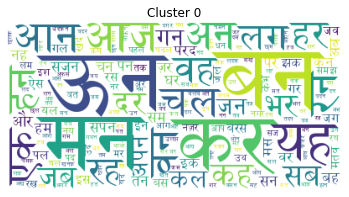

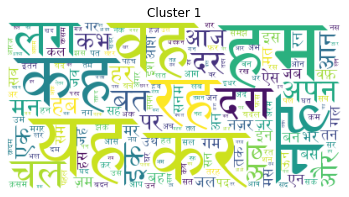

Index(['अए', 'अक', 'अकदकद', 'अकदन', 'अकबर', 'अकल', 'अख', 'अखब', 'अग', 'अगदम',
       ...
       'फ़लक़', 'फ़श', 'फ़स', 'फ़सद', 'फ़सल', 'फ़क़', 'फ़क़त', 'फ़ज़', '२क', '२०थ'],
      dtype='object', length=1416)
Results for k=3:
(3, 1416) (800, 1416)


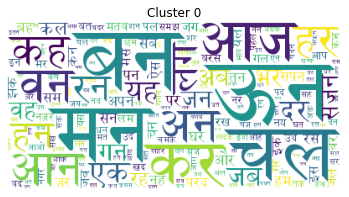

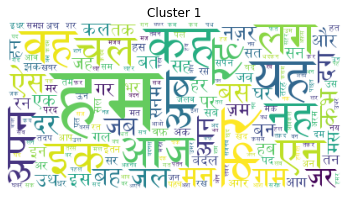

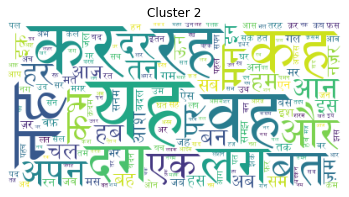

Index(['अए', 'अक', 'अकदकद', 'अकदन', 'अकबर', 'अकल', 'अख', 'अखब', 'अग', 'अगदम',
       ...
       'फ़लक़', 'फ़श', 'फ़स', 'फ़सद', 'फ़सल', 'फ़क़', 'फ़क़त', 'फ़ज़', '२क', '२०थ'],
      dtype='object', length=1416)
Results for k=4:
(4, 1416) (800, 1416)


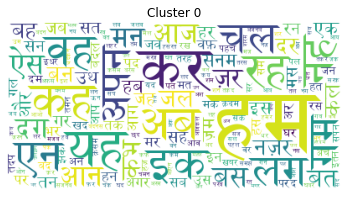

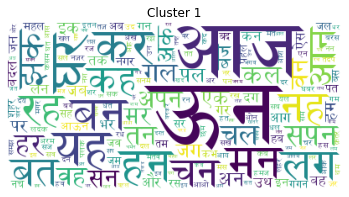

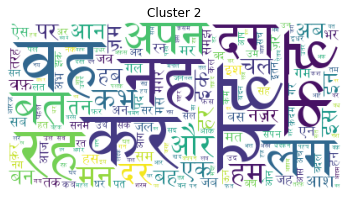

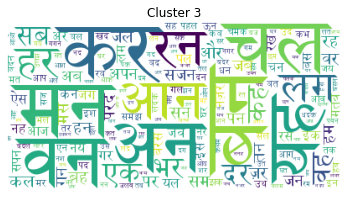

Index(['अए', 'अक', 'अकदकद', 'अकदन', 'अकबर', 'अकल', 'अख', 'अखब', 'अग', 'अगदम',
       ...
       'फ़लक़', 'फ़श', 'फ़स', 'फ़सद', 'फ़सल', 'फ़क़', 'फ़क़त', 'फ़ज़', '२क', '२०थ'],
      dtype='object', length=1416)
Results for k=5:
(5, 1416) (800, 1416)


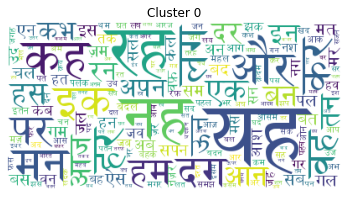

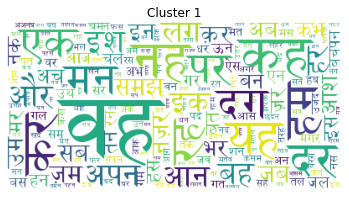

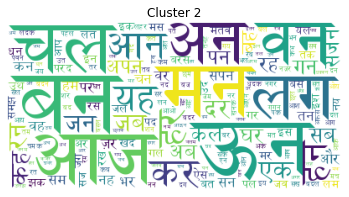

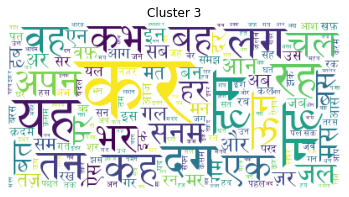

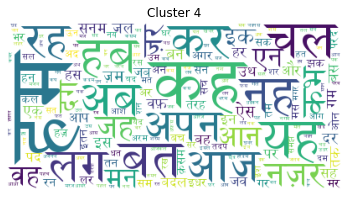

Index(['अए', 'अक', 'अकदकद', 'अकदन', 'अकबर', 'अकल', 'अख', 'अखब', 'अग', 'अगदम',
       ...
       'फ़लक़', 'फ़श', 'फ़स', 'फ़सद', 'फ़सल', 'फ़क़', 'फ़क़त', 'फ़ज़', '२क', '२०थ'],
      dtype='object', length=1416)
Results for k=6:
(6, 1416) (800, 1416)


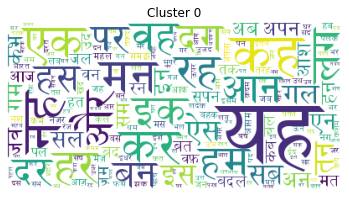

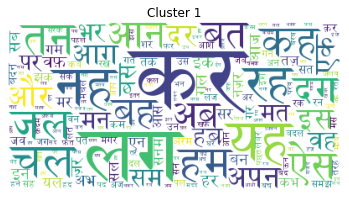

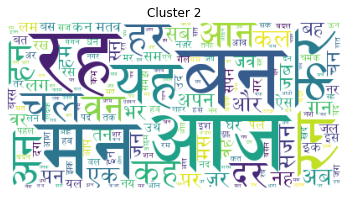

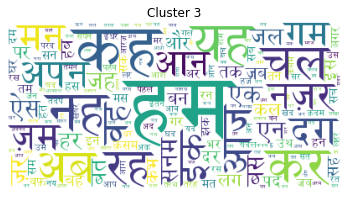

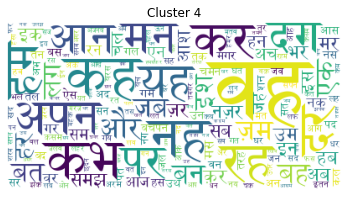

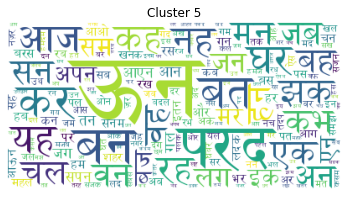

Index(['अए', 'अक', 'अकदकद', 'अकदन', 'अकबर', 'अकल', 'अख', 'अखब', 'अग', 'अगदम',
       ...
       'फ़लक़', 'फ़श', 'फ़स', 'फ़सद', 'फ़सल', 'फ़क़', 'फ़क़त', 'फ़ज़', '२क', '२०थ'],
      dtype='object', length=1416)
Results for k=7:
(7, 1416) (800, 1416)


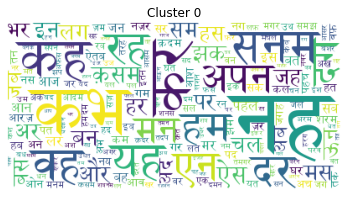

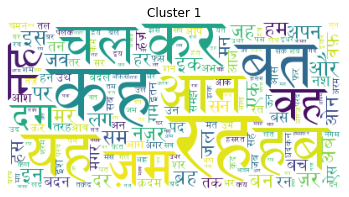

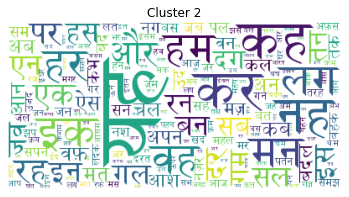

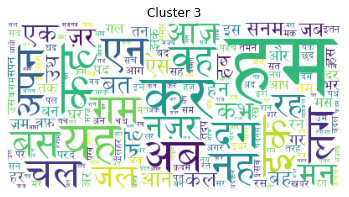

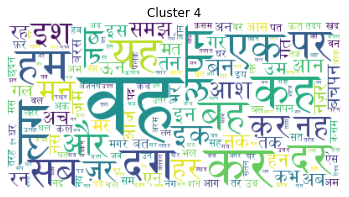

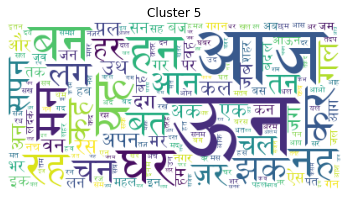

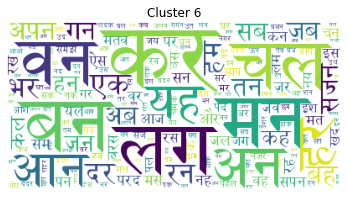

Index(['अए', 'अक', 'अकदकद', 'अकदन', 'अकबर', 'अकल', 'अख', 'अखब', 'अग', 'अगदम',
       ...
       'फ़लक़', 'फ़श', 'फ़स', 'फ़सद', 'फ़सल', 'फ़क़', 'फ़क़त', 'फ़ज़', '२क', '२०थ'],
      dtype='object', length=1416)
Results for k=8:
(8, 1416) (800, 1416)


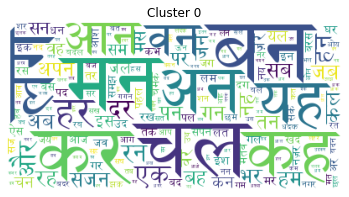

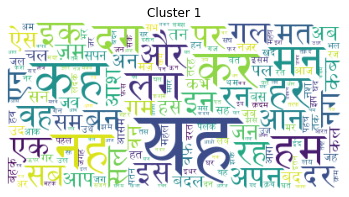

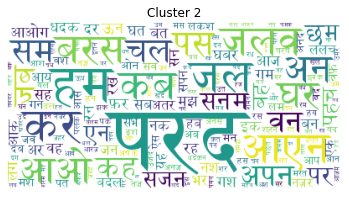

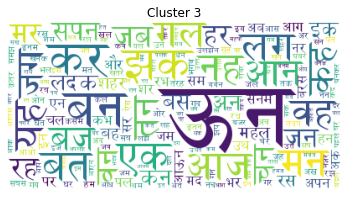

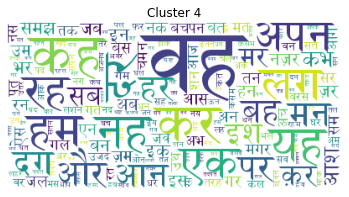

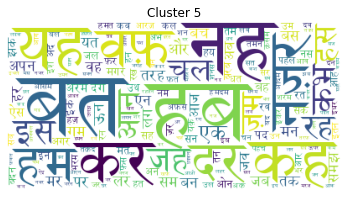

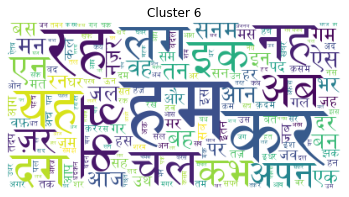

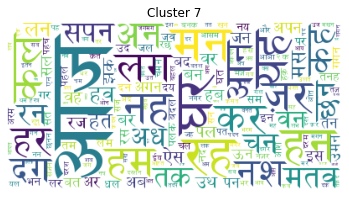

Index(['अए', 'अक', 'अकदकद', 'अकदन', 'अकबर', 'अकल', 'अख', 'अखब', 'अग', 'अगदम',
       ...
       'फ़लक़', 'फ़श', 'फ़स', 'फ़सद', 'फ़सल', 'फ़क़', 'फ़क़त', 'फ़ज़', '२क', '२०थ'],
      dtype='object', length=1416)
Results for k=9:
(9, 1416) (800, 1416)


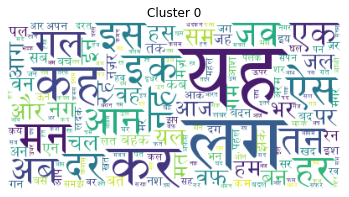

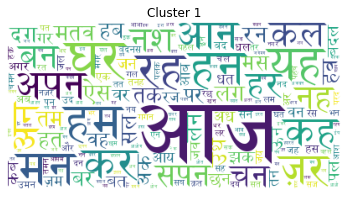

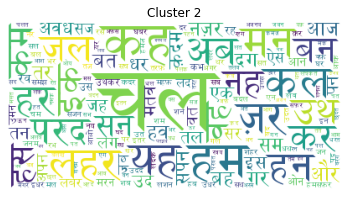

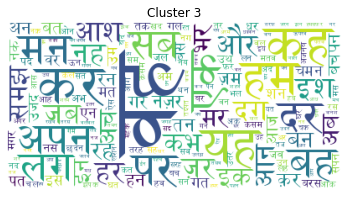

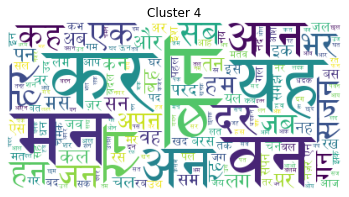

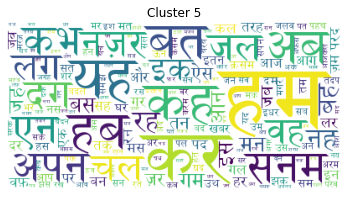

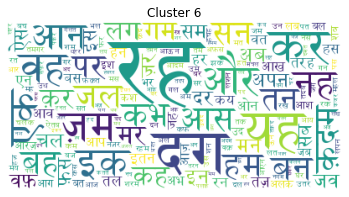

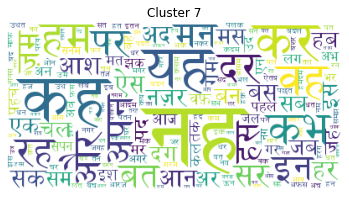

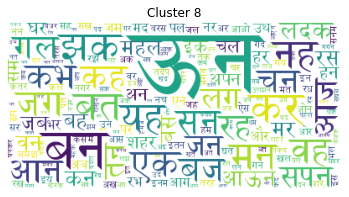

Index(['अए', 'अक', 'अकदकद', 'अकदन', 'अकबर', 'अकल', 'अख', 'अखब', 'अग', 'अगदम',
       ...
       'फ़लक़', 'फ़श', 'फ़स', 'फ़सद', 'फ़सल', 'फ़क़', 'फ़क़त', 'फ़ज़', '२क', '२०थ'],
      dtype='object', length=1416)


In [22]:
for k, kmeans in kmeans_results.items():
    print(f"Results for k={k}:")
    
    # Get the centroids
    centroids = pd.DataFrame(kmeans.cluster_centers_)
    print(centroids.shape,final_df.shape)
    centroids.columns = final_df.columns  # Exclude the last column ('label')
    
    # Generate word clouds
    generateWordClouds(centroids)
    print(final_df.columns)
    # # Plot the percentage of songs from each decade in each cluster
    # final_df['label'] = kmeans.labels_
    # plot_decade_distribution(final_df)
    
    # Add any other analysis you want to perform for each k

In [23]:
for k, kmeans in kmeans_results.items():
    sample = X
    clusters = kmeans.predict(sample)
    for i, sentence in enumerate(data.to_numpy()):
        print(clusters[i], sentence[-1])
    break

0 0.12590799031476999
0 0.034210526315789476
0 0.08232445520581114
0 0.06299212598425197
0 0.06485355648535565
1 0.11398040961709706
0 0.03764320785597381
0 0.08960573476702509
0 0.11368421052631579
0 0.06302521008403361
0 0.03859649122807018
0 0.1522248243559719
1 0.19183673469387755
0 0.1021021021021021
1 0.053388090349075976
1 0.03465982028241335
1 0.04451510333863275
0 0.14157119476268412
0 0.060291060291060294
0 0.03937007874015748
1 0.1182033096926714
1 0.07494145199063232
0 0.03305785123966942
0 0.045364891518737675
1 0.05198358413132695
0 0.05235602094240838
1 0.05405405405405406
0 0.11353711790393013
0 0.06432748538011696
1 0.09320388349514563
0 0.08469055374592833
0 0.13214285714285715
0 0.08791208791208792
0 0.06284153005464481
0 0.06936416184971098
0 0.06561679790026247
0 0.05562422744128554
0 0.09428571428571429
1 0.05112219451371571
0 0.03346456692913386
0 0.03377110694183865
1 0.04057971014492753
0 0.09853249475890985
0 0.054945054945054944
0 0.07083333333333333
1 0.1043

/home/rushil/.local/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


### Preparing our final groups for visualization

Now that we're satisfied with our clustering we should assign which country belongs to which group.

In [24]:
# Assigning the cluster labels to each country
labels = kmeans.labels_ 
data['label'] = labels
data.head()

Title                       Film  \
0                  kaun hai kisakaa miit muurakh                   abhaagin   
1                    baabaa man kii aankhen khol               dhoop chhaon   
2                    khet kii muulii baag ko aam               achhut kanya   
3  yaad terii aaii hai kaalii ghataa chhaaii hai  nadi kinaare on the river   
4                ek chhotaa sa mandir banaayenge          gramophone singer   

   Year                   Singer         Composer            Lyricist  \
0  1938     akbar khan peshawari        r c boral               arzoo   
1  1935                  k c dey  rai chand boral                 NaN   
2  1936  ashok kumar devika rani   saraswati devi  j s kashyap natawa   
3  1939                gyan dutt        gyan dutt                 NaN   
4  1938            surendra nath      anil biswas         zia sarhadi   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Lyrics  \
0  \tkaun hai\tkaun hai\tkaun hai kisakaa miit muurakh kaun hai kisakaa miit\tkaun hai kisakaa miit muurakh kaun hai kisakaa miit\tbach thokar se raah badal de\tbach thokar se raah badal de\triit to kar anariit muurakh kaun hai kisakaa miit kaun hai kisakaa miit muurakh kaun hai kisakaa miit\triit to kar anariit muurakh kaun hai kisakaa miit kaun hai kisakaa miit muurakh kaun hai kisakaa miit\thaan phuul kii baas khatak ko detii kaun na dhokhaa khaaye aan phulawaarii se ban hii achchhaa jo na dukh haan pahunchaaye kapat bane na priit muurakh kaun hai kisakaa miit kaun hai kisakaa miit kaun hai kisakaa miit muurakh kaun hai kisakaa miit\tsukh kii khoj lagaa ke tuune dagardagar dukh paaye\tsukh kii khoj lagaa ke tuune dagardagar dukh paaye\tdukhon kii duniyaa men bhii phir le shaayad sukh mil jaaye\tdukhon kii duniyaa men bhii phir le shaayad sukh mil jaaye\thaar men nikale jiit muurakh kaun hai kisakaa miit kaun hai kisakaa miit muurakh kaun hai kisakaa miit    
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               produced bynew theatres ltd directed bynitin bose\tbaabaa man kii aankhen khol man kii aankhen khol baabaa\tduniyaa kyaa hai ek tamaashaa chaar dinon kii jhuuthii aashaa pal men tolaa pal men maashaa gyaan taraazu leke haath men tol sake to tol baabaa man kii\tmatalab kii sab duniyaadaarii matalab ke sab hain sansaarii jag men teraa ho hitakaarii tan man kaa sab jor lagaakar naam hari kaa bol baabaa man kii\t   
2                                                                                                                                                                                                        